Goal: To predict The Salary Based on some of the Factors of the Job Position

In [1]:
import glassdoor_scraper as gs


import pandas as pd

import sys

import re

import matplotlib.pyplot as plt

import plotly.express as px

import numpy as np

import scipy

import sklearn

import seaborn as sns

from datetime import datetime, timedelta

from matplotlib import dates as mpl_dates

from matplotlib.animation import FuncAnimation

import nltk

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

import flask


# 1. Scrapping Data

In [2]:
path = "C:/Users/enriq/Anaconda3/Lib/site-packages/selenium/webdriver/chrome/chromedriver.exe"

In [3]:
# df=gs.get_jobs("data scientist", 12, False, path, 15) # didnt work for me 

In [4]:
df = pd.read_csv(r"C:\Users\enriq\Your_env_name_Notebooks\Github_Project_Ken\glassdoor_datascience_US.csv", engine="python", encoding='utf-8', error_bad_lines=False)

Skipping line 753: unexpected end of data


# 2. Data cleaning

In [5]:
pd.set_option("display.max_rows", 90)

In [6]:
pd.set_option("display.max_columns", 40)

In [7]:
df.dtypes

Unnamed: 0             int64
Job Title             object
Salary Estimate       object
Job Description       object
Rating               float64
Company Name          object
Location              object
Headquarters          object
Size                  object
Founded                int64
Type of ownership     object
Industry              object
Sector                object
Revenue               object
Competitors           object
dtype: object

In [8]:
df.columns = df.columns.str.lower() # Making title columns lower case

In [9]:
filt = df["salary estimate"].str.contains("Per Hour")

In [10]:
df["salary estimate"].loc[filt]

197             $17-$24 Per Hour(Glassdoor est.)
209             $21-$34 Per Hour(Glassdoor est.)
240             $18-$25 Per Hour(Glassdoor est.)
247             $21-$34 Per Hour(Glassdoor est.)
257             $15-$25 Per Hour(Glassdoor est.)
307             $17-$24 Per Hour(Glassdoor est.)
337             $21-$34 Per Hour(Glassdoor est.)
427             $18-$25 Per Hour(Glassdoor est.)
437             $24-$39 Per Hour(Glassdoor est.)
456             $21-$34 Per Hour(Glassdoor est.)
464    Employer Provided Salary:$25-$28 Per Hour
522             $21-$29 Per Hour(Glassdoor est.)
523             $10-$17 Per Hour(Glassdoor est.)
632             $18-$25 Per Hour(Glassdoor est.)
652             $24-$39 Per Hour(Glassdoor est.)
682             $21-$34 Per Hour(Glassdoor est.)
694    Employer Provided Salary:$25-$28 Per Hour
Name: salary estimate, dtype: object

In [11]:
df["hourly"] = filt

In [12]:
pattern = re.compile(r"[\d{2}]+")

In [13]:
lista = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] != 1 and len(x) > 1:
        try:
            x[0] = int(x[0])
            x[1] = int(x[1])
            x=pd.Series(x).mean()
        except IndexError:
            pass
    elif x[0]==1:
        x=np.nan
    else:
        x=int(x[0])
    lista.append(x)


In [14]:
df["salary_average"] = pd.Series(lista)

In [15]:
df["salary_average"].replace(1, np.nan, inplace=True)

In [16]:
lista2 = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] != "1":
        try:
            x = int(x[0])
        except IndexError:
            pass
    elif x[0] == "1":
        x=np.nan
    
    lista2.append(x)

In [17]:
df["salary_min"] = pd.Series(lista2)

In [18]:
lista3 = [] # salary parsing
for i in df["salary estimate"]:
    x = pattern.findall(i)
    if x[0] == "1":
        x=np.nan
    elif x[0] != "1":
        try:
            x = int(x[1])
        except IndexError:
            pass
    lista3.append(x)

In [19]:
df["salary_max"] = pd.Series(lista3)

In [20]:
df_splitted = df["location"].str.split(",", expand=True) # city/state columns

In [21]:
df = pd.concat([df, df_splitted], axis=1)

In [22]:
df = df.drop(["location",2], axis=1)

In [23]:
df.rename(columns={0:"city", 1: "state"}, inplace=True)

In [24]:
df.head()

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,91.0,Albuquerque,NM
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,112.0,Linthicum,MD
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,90.0,Clearwater,FL
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,97.0,Richland,WA
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,143.0,New York,NY


In [25]:
pattern2 = re.compile(r"\d*\.?\d+") # pattern to parse a decimal number from within a string

In [26]:
pattern2.findall(df["company name"][0])

['3.8']

In [27]:
lista4=[]
for i in df["company name"]:
    x = pattern2.findall(i)
    lista4.append(x)


In [28]:
lista4 = pd.Series(lista4)

In [29]:
lista4 = lista4.astype(str).str.replace("]","").str.replace("[","").str.replace("'","")

In [30]:
lista5 = [] # parsing decimal number from company column
for i in lista4:
    if len(i)==3:
        i = float(i)
        lista5.append(i)
    else:
        lista5.append(i)

In [31]:
lista5 = pd.Series(lista5)

In [32]:
df["parsed_num"] = lista5

In [33]:
lista6 = [] # changing to datetime if format allows it. Otherwise, dont change anything
for i in range(len(df["founded"])):
    try:
        x=pd.to_datetime(df["founded"][i], format="%Y")
        lista6.append(x)
    except ValueError:
        lista6.append(df["founded"][i])

In [34]:
len(lista6)

751

In [35]:
lista7 = [] # Now we obtain the delta times. we had to deal with few -1 values
for i in lista6:
    if i != -1:
        x=round((datetime.now()-i).days/365)
        lista7.append(x)
    else:
        lista7.append(i)

In [36]:
df["years_old"] = pd.Series(lista7)

In [37]:
df["years_old"].replace(-1,np.nan, inplace=True) # converting those -1 values into nan

In [38]:
df["salary_average"].isna().sum()

160

In [39]:
df.head()

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,91.0,Albuquerque,NM,3.8,47.0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,112.0,Linthicum,MD,3.4,36.0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,90.0,Clearwater,FL,"4, 4.8",10.0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,97.0,Richland,WA,3.8,55.0
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,143.0,New York,NY,2.9,22.0


In [40]:
df["company_txt"] = df.apply(lambda x: x["company name"].replace("\n","").replace("\r", "") if x["rating"]<0 else x["company name"][:-3].replace("\n","").replace("\r", ""), axis=1)

In [41]:
df

,unnamed: 0,job title,salary estimate,job description,rating,company name,headquarters,size,founded,type of ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,91.0,Albuquerque,NM,3.8,47.0,Tecolote Research
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,112.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,90.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,97.0,Richland,WA,3.8,55.0,PNNL
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,143.0,New York,NY,2.9,22.0,Affinity Solutions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,746,"Technology-Minded, Data Professional Opportuni...",$40K-$101K (Glassdoor est.),"At VU, we help Veterans buy homes. To make tha...",4.7,Veterans United Home Loans\r\n4.7,"Columbia, MO",1001 to 5000 employees,2002,Company - Private,Lending,Finance,Unknown / Non-Applicable,-1,False,70.5,40.0,101.0,Columbia,MO,4.7,18.0,Veterans United Home Loans
747,747,Big Data Engineer,$84K-$153K (Glassdoor est.),Overview\r\n\r\n\r\nTechnology is constantly c...,3.3,Peraton\r\n3.3,"Herndon, VA",1001 to 5000 employees,2017,Company - Private,Aerospace & Defense,Aerospace & Defense,$1 to $2 billion (USD),-1,False,118.5,84.0,153.0,Chantilly,VA,3.3,3.0,Peraton
748,748,Salesforce Analytics Consultant,$52K-$81K (Glassdoor est.),"Wave6, an Emtec company, innovates with cuttin...",3.9,"Emtec, Inc.\r\n3.9","Jacksonville, FL",501 to 1000 employees,1995,Company - Private,Enterprise Software & Network Solutions,Information Technology,$100 to $500 million (USD),-1,False,66.5,52.0,81.0,Chicago,IL,3.9,25.0,"Emtec, Inc."
749,749,Managing Data Scientist/ML Engineer,$81K-$134K (Glassdoor est.),Managing Data Scientist/ML Engineer\r\n\r\nApp...,3.4,PA Consulting\r\n3.4,"London, United Kingdom",1001 to 5000 employees,1943,Company - Private,Consulting,Business Services,$100 to $500 million (USD),"McKinsey & Company, Accenture, Deloitte",False,107.5,81.0,134.0,Boston,MA,3.4,77.0,PA Consulting


In [42]:
df["python"] = df["job description"].apply(lambda x: True if "python" in x.lower() else False)

In [43]:
df["R studio"] = df["job description"].apply(lambda x: True if " R " in x or "r-studio" in x.lower() else False)

In [44]:
df["spark"] = df["job description"].apply(lambda x: True if "spark" in x.lower() else False)

In [45]:
df["aws"] = df["job description"].apply(lambda x: True if "aws" in x.lower() else False)

In [46]:
df["excell"] = df["job description"].apply(lambda x: True if "excell" in x.lower() else False)

In [47]:
df["SQL"] = df["job description"].apply(lambda x: True if "sql" in x.lower() else False)

In [48]:
df["SQL"].value_counts()

True     385
False    366
Name: SQL, dtype: int64

In [49]:
lista_sql = pd.Series([True if "SQL" in df["job description"][i] else False for i in range(len(df["job description"]))]) # list comprehension with else statement 

In [50]:
lista_sql.value_counts()

True     385
False    366
dtype: int64

In [51]:
df = df.drop("unnamed: 0", axis=1)

In [52]:
# lets create a function that help us to generate a column with job positions
# grouped in 7 different categories

def title_categorizer(title):
    if "data scientist" in title.lower():
        return "data scientist"
    elif "data engineer" in title.lower():
        return "data engineer"
    elif "analyst" in title.lower():
        return "analyst"
    elif "machine learning" in title.lower():
        return "ML"
    elif "manager" in title.lower():
        return "manager"
    elif "director" in title.lower():
        return "director"
    else:
        return np.nan

In [53]:
# we will also create a function to categorise the level of experience of the positions
# This is how we can parse specific info from a column
def experience(title):
    if "sr" in title.lower() or "senior" in title.lower() or "lead" in title.lower()  or "manager" in title.lower()  or "principal" in title.lower() or "chief" in title.lower():
        return "senior"
    elif "jr" in title.lower() or "junior" in title.lower():
        return "junior"
    else:
        return np.nan

In [54]:
df["title_category"] = df["job title"].apply(title_categorizer)

In [55]:
df["title_category"].value_counts(dropna=False)

data scientist    295
NaN               178
data engineer     125
analyst            99
manager            24
ML                 20
director           10
Name: title_category, dtype: int64

In [56]:
df["experience_level"] = df["job title"].apply(experience)

In [57]:
df["experience_level"].value_counts(dropna=False)

NaN       520
senior    229
junior      2
Name: experience_level, dtype: int64

In [58]:
df["state"] = df["state"].str.replace("Los Angeles", "CA") # Replacing Los Angeles for LA because there was one Los Angeles instead of LA
df["state"] = df["state"].str.strip() # this will remove white spaces in the column

In [59]:
df.columns = df.columns.str.replace(" ", "_") # Lets remove spaces and replace them with _ for consistancy

In [60]:
# also lets create a new column with the len of the description since it can be an interesting parameter
df["description_len"] = df["job_description"].str.len()

In [61]:
# Create a column with the number of competitors
df["compet_nums"] = df["competitors"].apply(lambda x: len(x.split(",")) if x != "-1" else 0)

In [62]:
df.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'headquarters', 'size', 'founded', 'type_of_ownership',
       'industry', 'sector', 'revenue', 'competitors', 'hourly',
       'salary_average', 'salary_min', 'salary_max', 'city', 'state',
       'parsed_num', 'years_old', 'company_txt', 'python', 'R_studio', 'spark',
       'aws', 'excell', 'SQL', 'title_category', 'experience_level',
       'description_len', 'compet_nums'],
      dtype='object')

In [63]:
# another thing that we should do it to recalculate the hourly salaries to annual.
# We can do this as follows
df["salary_min"] = df.apply(lambda x: x["salary_min"]*2 if x["hourly"] == 1 else x["salary_min"], axis=1)
df["salary_max"] = df.apply(lambda x: x["salary_max"]*2 if x["hourly"] == 1 else x["salary_max"], axis=1)

In [64]:
df.loc[df["hourly"]==1,["hourly", "salary_min", "salary_max"]] # We just check if min < max after this adjustment

,hourly,salary_min,salary_max
197,True,34.0,48.0
209,True,42.0,68.0
240,True,36.0,50.0
247,True,42.0,68.0
257,True,30.0,50.0
307,True,34.0,48.0
337,True,42.0,68.0
427,True,36.0,50.0
437,True,48.0,78.0
456,True,42.0,68.0


In [65]:
df.head()

,job_title,salary_estimate,job_description,rating,company_name,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt,python,R_studio,spark,aws,excell,SQL,title_category,experience_level,description_len,compet_nums
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,91.0,Albuquerque,NM,3.8,47.0,Tecolote Research,True,False,False,False,True,False,data scientist,NaN,2555,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,112.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System,True,False,False,False,False,False,data scientist,NaN,4828,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,90.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4,True,True,True,False,False,True,data scientist,NaN,3495,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,97.0,Richland,WA,3.8,55.0,PNNL,True,False,False,False,False,False,data scientist,NaN,3926,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,143.0,New York,NY,2.9,22.0,Affinity Solutions,True,False,False,False,True,True,data scientist,NaN,2748,3


In [66]:
df.to_csv("Ken Project Data Cleaned.csv", index=False)

In [67]:
df2 = pd.read_csv("Ken Project Data Cleaned.csv")

# 3. EDA (Exploratory Data Analysis)

In [68]:
df2.head()

,job_title,salary_estimate,job_description,rating,company_name,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt,python,R_studio,spark,aws,excell,SQL,title_category,experience_level,description_len,compet_nums
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",3.8,Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,False,72.0,53.0,91.0,Albuquerque,NM,3.8,47.0,Tecolote Research,True,False,False,False,True,False,data scientist,NaN,2555,0
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,3.4,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,False,87.5,63.0,112.0,Linthicum,MD,3.4,36.0,University of Maryland Medical System,True,False,False,False,False,False,data scientist,NaN,4828,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,False,85.0,80.0,90.0,Clearwater,FL,"4, 4.8",10.0,KnowBe4,True,True,True,False,False,True,data scientist,NaN,3495,0
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,3.8,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",False,76.5,56.0,97.0,Richland,WA,3.8,55.0,PNNL,True,False,False,False,False,False,data scientist,NaN,3926,3
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,2.9,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",False,114.5,86.0,143.0,New York,NY,2.9,22.0,Affinity Solutions,True,False,False,False,True,True,data scientist,NaN,2748,3


In [69]:
df2.dtypes

job_title             object
salary_estimate       object
job_description       object
rating               float64
company_name          object
headquarters          object
size                  object
founded                int64
type_of_ownership     object
industry              object
sector                object
revenue               object
competitors           object
hourly                  bool
salary_average       float64
salary_min           float64
salary_max           float64
city                  object
state                 object
parsed_num            object
years_old            float64
company_txt           object
python                  bool
R_studio                bool
spark                   bool
aws                     bool
excell                  bool
SQL                     bool
title_category        object
experience_level      object
description_len        int64
compet_nums            int64
dtype: object

In [70]:
df["salary_max"].unique()

array([ 91., 112.,  90.,  97., 143., 119.,  93., 142.,  84., 160., 201.,
       106., 172.,  85., 144., 190., 137., 189., 175., 111., 130., 139.,
       105.,  nan, 177., 110., 124.,  61., 120., 149., 140., 135., 132.,
       180., 138., 129., 113., 150., 211.,  39., 117.,  99., 114.,  95.,
       176., 146., 109., 148.,  72., 161.,  81., 220., 102., 122., 157.,
       222., 118., 141., 154.,  76., 100.,  68., 107.,  65.,  62., 231.,
       134., 116., 123.,  73., 164., 153., 275.,  71., 193., 163., 101.,
       133., 125., 173., 159.,  50.,  55., 182., 223., 145., 115., 136.,
       167., 204.,  78., 207., 174.,  80.,  48.,  82., 185., 198., 250.,
       206., 183., 166., 179., 127., 224.,  66.,  86.,  92., 103.,  64.,
        16., 199., 126.,  63., 194.,  74., 208., 162., 209.,  89., 202.,
        57., 200., 196., 171., 306.,  59., 158.,  56., 155.,  98.,  96.,
       210.,  77., 221., 147., 151., 203., 178.,  58.,  34., 239.,  88.,
       181., 289., 188., 228., 184., 108., 215., 12

In [71]:
df2.describe()

,rating,founded,salary_average,salary_min,salary_max,years_old,description_len,compet_nums
count,751.000000,751.000000,591.000000,591.000000,591.000000,681.000000,751.000000,751.000000
mean,3.642344,1790.671105,101.276650,75.301184,128.664975,45.265786,3801.675100,0.892144
std,1.033256,576.984838,38.857585,31.335916,45.177459,52.840421,1562.245456,1.327787
min,-1.000000,-1.000000,13.500000,15.000000,16.000000,1.000000,695.000000,0.000000
25%,3.400000,1939.000000,73.500000,52.000000,96.000000,11.000000,2751.000000,0.000000
50%,3.800000,1993.000000,98.000000,71.000000,124.000000,24.000000,3604.000000,0.000000
75%,4.200000,2008.000000,124.000000,92.500000,157.500000,55.000000,4671.000000,3.000000
max,5.000000,2019.000000,254.000000,202.000000,306.000000,277.000000,10146.000000,4.000000


In [72]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


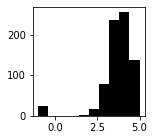

In [73]:

fig, ax = plt.subplots(1, figsize=(2, 2))
plt.style.use("seaborn-notebook")
plt.hist(df2["rating"], color="k")
plt.show()

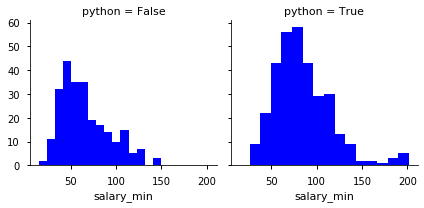

In [74]:
g = sns.FacetGrid(df2, col="python", hue="hourly")
g = g.map(plt.hist, "salary_min",bins=15, color="b")

In [75]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
boolean = ['bool']
categorical = ['object']
numeric_df = df2.select_dtypes(include=numerics)
boolean_df = df2.select_dtypes(include=boolean)
categorical_df = df2.select_dtypes(include=categorical)

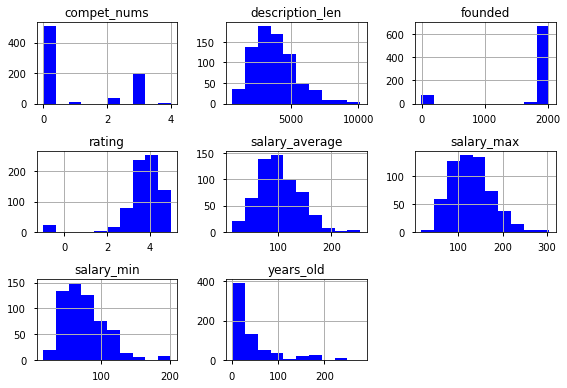

In [76]:
numeric_df.hist(color="b")
plt.tight_layout()
plt.savefig("histograms.png", dpi=300)
plt.show()

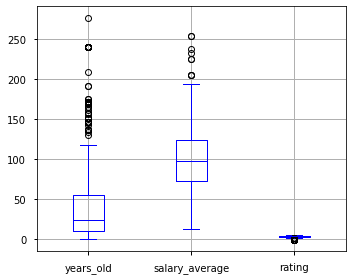

In [77]:
fig, ax = plt.subplots(1, figsize=(5, 4))
numeric_df[["years_old", "salary_average", "rating"]].boxplot(color="b")
plt.tight_layout()
plt.show()

In [78]:
numeric_df.corr()

,rating,founded,salary_average,salary_min,salary_max,years_old,description_len,compet_nums
rating,1.000000,0.467494,0.003109,-0.015034,0.012705,-0.164754,-0.016731,0.010233
founded,0.467494,1.000000,-0.005909,-0.021799,0.012675,-0.999995,0.105303,0.194682
salary_average,0.003109,-0.005909,1.000000,0.968731,0.987120,0.017731,0.054220,0.097298
salary_min,-0.015034,-0.021799,0.968731,1.000000,0.938444,0.005142,0.042275,0.082589
salary_max,0.012705,0.012675,0.987120,0.938444,1.000000,0.029739,0.049246,0.089481
years_old,-0.164754,-0.999995,0.017731,0.005142,0.029739,1.000000,0.143882,0.114349
description_len,-0.016731,0.105303,0.054220,0.042275,0.049246,0.143882,1.000000,0.163917
compet_nums,0.010233,0.194682,0.097298,0.082589,0.089481,0.114349,0.163917,1.000000


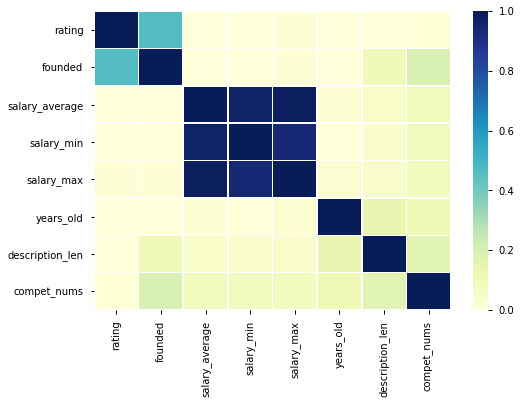

In [79]:
ax = sns.heatmap(numeric_df.corr(), cmap="YlGnBu",linewidths=.5, vmin=0, vmax=1)
plt.rcParams["figure.figsize"] = (20,20)
plt.savefig("corr_plot.png", dpi=400, bbox_inches='tight')

In [80]:
categorical_df.head()

,job_title,salary_estimate,job_description,company_name,headquarters,size,type_of_ownership,industry,sector,revenue,competitors,city,state,parsed_num,company_txt,title_category,experience_level
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\r\nLocation: Albuquerque, NM\r\...",Tecolote Research\r\n3.8,"Goleta, CA",501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,Albuquerque,NM,3.8,Tecolote Research,data scientist,NaN
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\r\n\r\nI. General Summary\r\...,University of Maryland Medical System\r\n3.4,"Baltimore, MD",10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,Linthicum,MD,3.4,University of Maryland Medical System,data scientist,NaN
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",KnowBe4\r\n4.8,"Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,Clearwater,FL,"4, 4.8",KnowBe4,data scientist,NaN
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\r\nJob ID: 310709\r...,PNNL\r\n3.8,"Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa...",Richland,WA,3.8,PNNL,data scientist,NaN
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\r\nAffinity Solutions / Marketi...,Affinity Solutions\r\n2.9,"New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",New York,NY,2.9,Affinity Solutions,data scientist,NaN


In [81]:
x=categorical_df["state"].value_counts().index
y=categorical_df["state"].value_counts().values

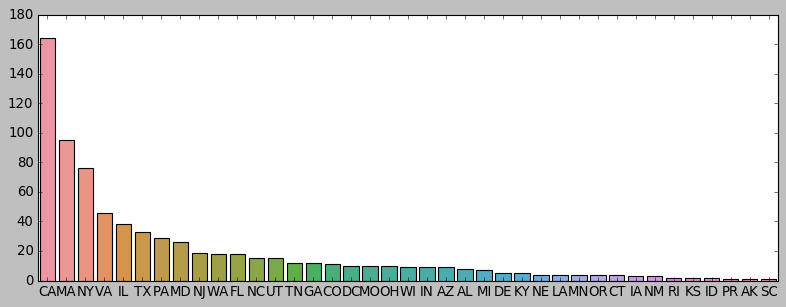

In [82]:
plt.style.use("classic")
fig, ax = plt.subplots(1, figsize=(10, 4))
sns.barplot(x,y)
plt.tight_layout()
plt.show()

In [83]:
# how to generate multiple bars?

v=categorical_df["title_category"].value_counts().index
z=categorical_df["title_category"].value_counts().values
xx = np.arange(6)
extra_y=z*1.2 
labels_xx = ["", 'data scientist', 'data engineer', 'analyst', 'manager', 'ML',
       'director', ""]

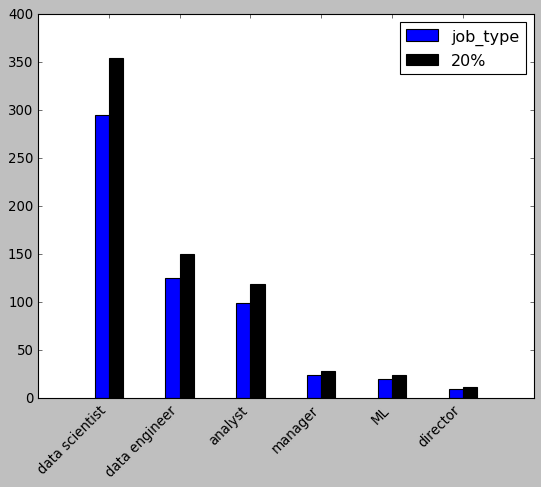

In [84]:
ax = plt.subplot()
ax.bar(xx-0.1, z, width=0.2, color='b', align="center", label="job_type")
ax.bar(xx+0.1, extra_y, width=0.2, color='k', align="center", label="20%")
ax.set_xticklabels(labels_xx, rotation=45, fontsize=12,ha="right")
ax.legend()
plt.rcParams["figure.figsize"] = (5,5)
plt.xlim(-1, 6)
plt.savefig("barstack.png", dpi=400)
plt.show()


In [85]:
series_z = pd.Series(z)
series_z2 =pd.Series(extra_y)
df_bar=pd.DataFrame({"S1":series_z, "S2":series_z2})

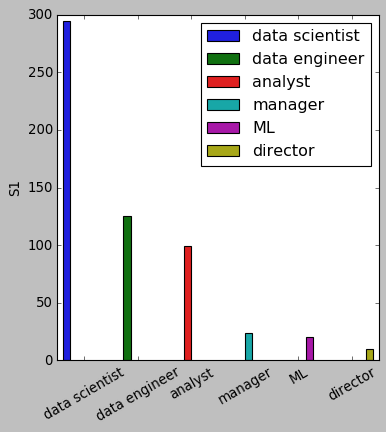

In [86]:
sns.barplot(x=v, hue=v, y="S1", data=df_bar)
plt.tight_layout()
plt.xticks(rotation="30", fontsize=12)
plt.rcParams["figure.figsize"] = (3,3)

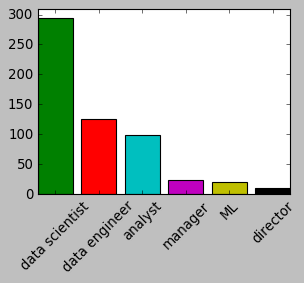

In [87]:
plt.style.use("classic")
fig, ax = plt.subplots(1, figsize=(4, 3))
plt.bar(v,z, color=["C1", "C2", "C3", "C4", "C5", "C6"])
plt.tight_layout()

plt.ylim(0, 310)
plt.xticks(rotation=45, fontsize=12)
plt.show()


Text(0.0, 0.55, 'Number of Positions Advertised')

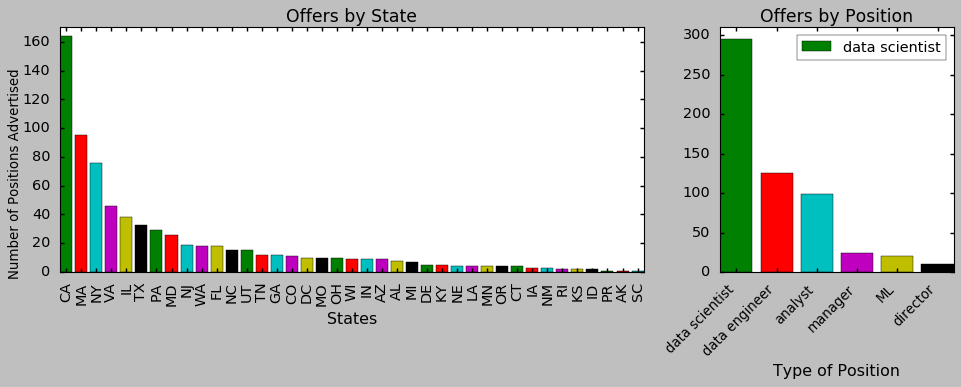

In [88]:
labels_ax2 = categorical_df["title_category"].value_counts().index
widths = [5, 2]
heights = [2]
gs_kw = dict(width_ratios=widths, height_ratios=heights, hspace=0)

plt.style.use("seaborn-talk")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=gs_kw)
ax1.bar(x,y, color=["C1", "C2", "C3", "C4", "C5", "C6"])
ax1.set(ylim=(0,170), xlabel="States")
ax1.set_title("Offers by State")

for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.bar(v,z, color=["C1", "C2", "C3", "C4", "C5", "C6"])
ax2.set_xticklabels(labels_ax2, rotation=45, fontsize=12,ha="right")
ax2.set(ylim=(0,310), xlabel="Type of Position")
ax2.set_title("Offers by Position")
ax2.legend(labels_ax2, bbox_to_anchor=(1, 1), loc= "best") # legend?
plt.tight_layout()
fig.text(0.0, 0.55,"Number of Positions Advertised", va='center', rotation='vertical', fontsize=12)
# fig.savefig("bar_subplots_ax1_ax2", dpi=400)


In [89]:
(categorical_df["title_category"].value_counts().values)*1.2

array([354. , 150. , 118.8,  28.8,  24. ,  12. ])

In [90]:
categorical_df["title_category"].value_counts().index

Index(['data scientist', 'data engineer', 'analyst', 'manager', 'ML',
       'director'],
      dtype='object')

In [91]:
categorical_df_simplif = categorical_df[["size", "sector", "industry", "state", "title_category"]]

graph for size: total = 9


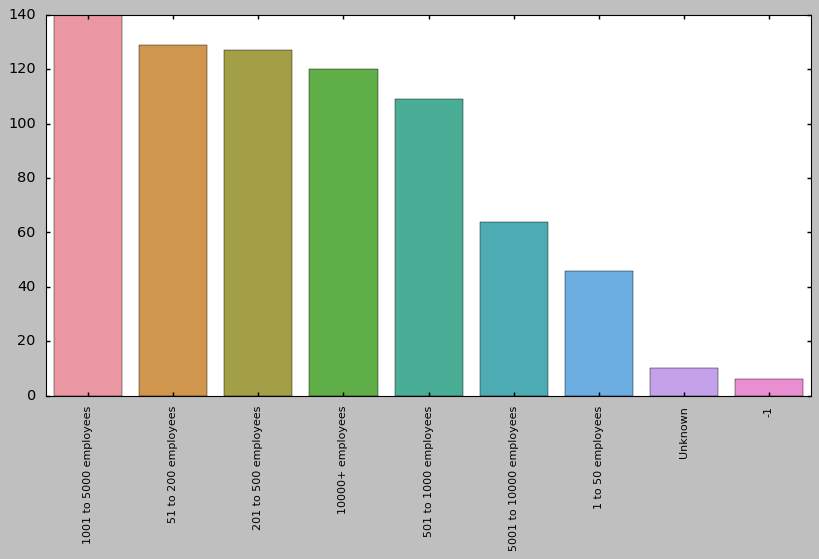

graph for sector: total = 25


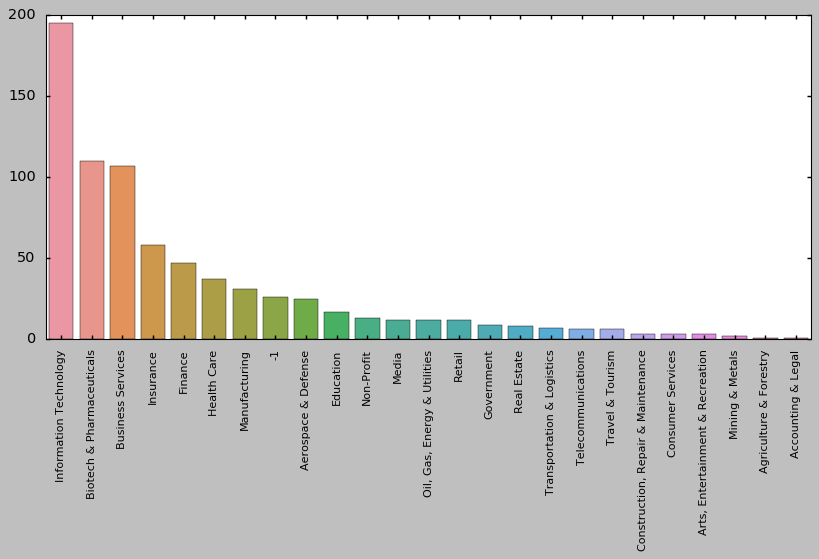

graph for industry: total = 62


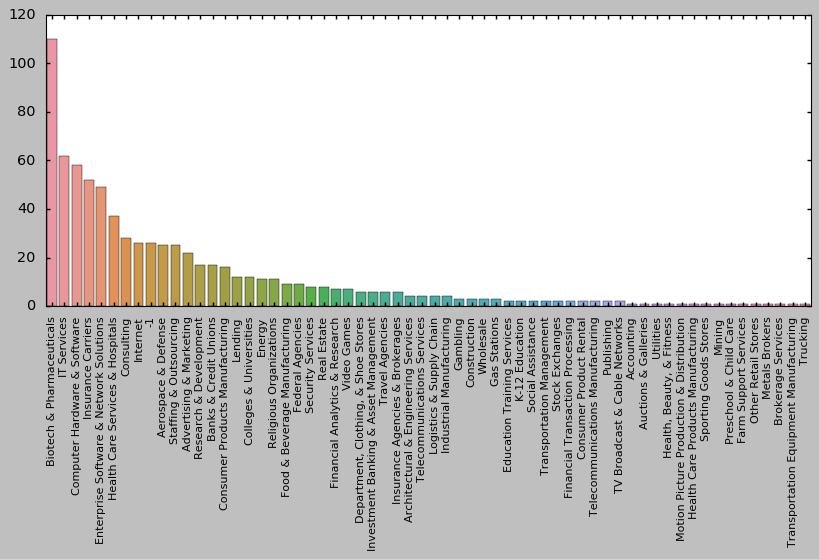

graph for state: total = 39


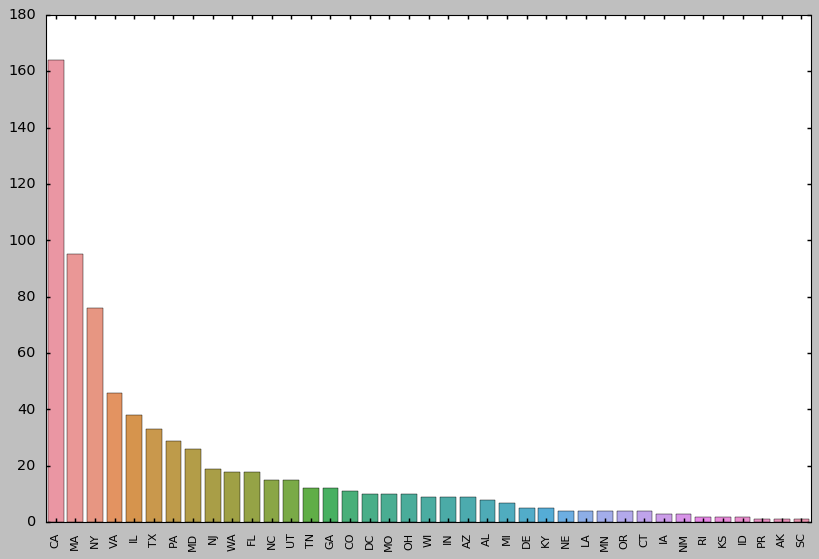

graph for title_category: total = 6


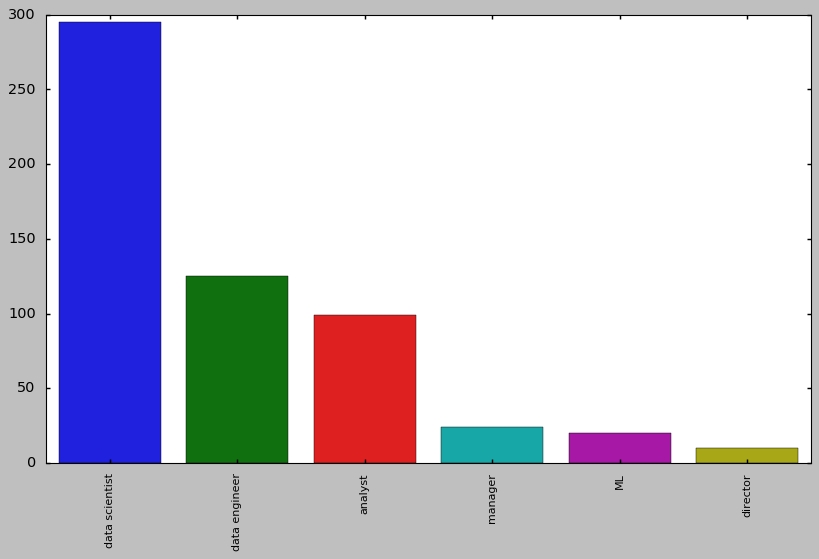

In [92]:
for i in categorical_df_simplif.columns:
    f=sns.barplot(x=categorical_df_simplif[i].value_counts().index, y=categorical_df_simplif[i].value_counts().values)
    print("graph for %s: total = %d" %(i, len(categorical_df_simplif[i].value_counts().index)))
    f.set_xticklabels(categorical_df_simplif[i].value_counts().index, rotation=90, fontsize=10)
    plt.tight_layout()
    plt.show()


In [93]:
pd.pivot_table(df2, index=["title_category","python"], values= ["salary_average","salary_min","salary_max"], aggfunc="mean")

salary_average  salary_max  salary_min
title_category python                                        
ML             False       124.000000  167.000000   81.000000
               True        136.000000  172.076923   99.923077
analyst        False        60.981132   79.000000   43.471698
               True         71.446429   92.071429   50.821429
data engineer  False       104.757576  133.818182   75.696970
               True        106.516667  135.566667   77.466667
data scientist False       116.166667  142.925926   89.407407
               True        118.984043  147.074468   90.893617
director       False       114.000000  149.333333   78.666667
               True        208.700000  254.000000  163.400000
manager        False        73.818182   99.090909   48.545455
               True         83.375000  105.250000   61.500000

In [94]:

# We can obtain the same result with groupby func
gbtitle = df2.groupby(["title_category", "python"])
gbtitle[["salary_average","salary_min","salary_max"]].mean()

salary_average  salary_min  salary_max
title_category python                                        
ML             False       124.000000   81.000000  167.000000
               True        136.000000   99.923077  172.076923
analyst        False        60.981132   43.471698   79.000000
               True         71.446429   50.821429   92.071429
data engineer  False       104.757576   75.696970  133.818182
               True        106.516667   77.466667  135.566667
data scientist False       116.166667   89.407407  142.925926
               True        118.984043   90.893617  147.074468
director       False       114.000000   78.666667  149.333333
               True        208.700000  163.400000  254.000000
manager        False        73.818182   48.545455   99.090909
               True         83.375000   61.500000  105.250000

In [95]:
# Once we created the groupby object we can also use get_group to get a particular sub_df
gbtitle.get_group(("manager", True))

,job_title,salary_estimate,job_description,rating,company_name,headquarters,size,founded,type_of_ownership,industry,sector,revenue,competitors,hourly,salary_average,salary_min,salary_max,city,state,parsed_num,years_old,company_txt,python,R_studio,spark,aws,excell,SQL,title_category,experience_level,description_len,compet_nums
146,Data Analytics Manager,$26K-$55K (Glassdoor est.),About You:\r\nWe are looking for a dedicated a...,3.8,Full Potential Solutions\r\n3.8,"Kansas City, MO",501 to 1000 employees,2017,Company - Private,Staffing & Outsourcing,Business Services,Unknown / Non-Applicable,-1,False,40.5,26.0,55.0,Kansas City,MO,3.8,3.0,Full Potential Solutions,True,False,False,True,True,True,manager,senior,4185,0
180,BI & Platform Analytics Manager,$85K-$134K (Glassdoor est.),A collective energy and ambition. A place wher...,3.4,Church & Dwight\r\n3.4,"Ewing, NJ",1001 to 5000 employees,1846,Company - Public,Consumer Products Manufacturing,Manufacturing,$2 to $5 billion (USD),-1,False,109.5,85.0,134.0,Ewing,NJ,3.4,175.0,Church & Dwight,True,True,False,False,False,False,manager,senior,2998,0
238,Data Science Manager,-1,Decode_M\r\n\r\nhttps://www.decode-m.com/\r\n\...,-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,False,NaN,NaN,NaN,New York,NY,NaN,NaN,Decode_M,True,False,False,False,True,False,manager,senior,3187,0
260,BI & Platform Analytics Manager,$85K-$134K (Glassdoor est.),A collective energy and ambition. A place wher...,3.4,Church & Dwight\r\n3.4,"Ewing, NJ",1001 to 5000 employees,1846,Company - Public,Consumer Products Manufacturing,Manufacturing,$2 to $5 billion (USD),-1,False,109.5,85.0,134.0,Ewing,NJ,3.4,175.0,Church & Dwight,True,True,False,False,False,False,manager,senior,2998,0
424,Data Science Manager,-1,Decode_M\r\n\r\nhttps://www.decode-m.com/\r\n\...,-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,False,NaN,NaN,NaN,New York,NY,NaN,NaN,Decode_M,True,False,False,False,True,False,manager,senior,3187,0
626,Data Science Manager,-1,Decode_M\r\n\r\nhttps://www.decode-m.com/\r\n\...,-1.0,Decode_M,"New York, NY",1 to 50 employees,-1,Unknown,-1,-1,Unknown / Non-Applicable,-1,False,NaN,NaN,NaN,New York,NY,NaN,NaN,Decode_M,True,False,False,False,True,False,manager,senior,3187,0
734,Product Manager/Data Evangelist,$50K-$98K (Glassdoor est.),Product Manager/Data EvangelistSUMMARY\r\n\r\n...,3.2,"Numeric, LLC\r\n3.2","Chadds Ford, PA",1 to 50 employees,-1,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),-1,False,74.0,50.0,98.0,Phila,PA,3.2,NaN,"Numeric, LLC",True,False,False,True,False,True,manager,senior,1817,0


In [96]:
pivot_df = pd.pivot_table(df2, index=["title_category","SQL"], values= ["salary_average","salary_min","salary_max"], aggfunc=('count','mean'))

In [97]:
pivot_df

salary_average             salary_max              \
                              count        mean      count        mean   
title_category SQL                                                       
ML             False              6  116.500000          6  155.166667   
               True              10  144.100000         10  180.700000   
analyst        False             22   53.022727         22   69.818182   
               True              59   68.915254         59   88.627119   
data engineer  False             24  110.166667         24  141.666667   
               True              69  104.405797         69  132.608696   
data scientist False            103  121.713592        103  149.873786   
               True             139  115.866906        139  143.388489   
director       False              6  174.083333          6  216.500000   
               True               2  170.500000          2  209.500000   
manager        False              6   90.166667          6  118.666667   
               True               9   67.166667          9   88.777778   

                     salary_min              
                          count        mean  
title_category SQL                           
ML             False          6   77.833333  
               True          10  107.500000  
analyst        False         22   37.454545  
               True          59   49.203390  
data engineer  False         24   78.666667  
               True          69   76.202899  
data scientist False        103   93.553398  
               True         139   88.345324  
director       False          6  131.666667  
               True           2  131.500000  
manager        False          6   61.666667  
               True           9   45.555556

In [98]:
unstacked = pivot_df.unstack()

In [99]:
unstacked

salary_average                               salary_max        \
                        count              mean                  count         
SQL                     False True        False       True       False True    
title_category                                                                 
ML                          6    10  116.500000  144.100000          6    10   
analyst                    22    59   53.022727   68.915254         22    59   
data engineer              24    69  110.166667  104.405797         24    69   
data scientist            103   139  121.713592  115.866906        103   139   
director                    6     2  174.083333  170.500000          6     2   
manager                     6     9   90.166667   67.166667          6     9   

                                       salary_min                    \
                      mean                  count              mean   
SQL                  False       True       False True        False   
title_category                                                        
ML              155.166667  180.700000          6    10   77.833333   
analyst          69.818182   88.627119         22    59   37.454545   
data engineer   141.666667  132.608696         24    69   78.666667   
data scientist  149.873786  143.388489        103   139   93.553398   
director        216.500000  209.500000          6     2  131.666667   
manager         118.666667   88.777778          6     9   61.666667   

                            
                            
SQL                  True   
title_category              
ML              107.500000  
analyst          49.203390  
data engineer    76.202899  
data scientist   88.345324  
director        131.500000  
manager          45.555556

In [100]:
# we can for instance create a pivot table to see the average salaries of the analysts among the different states

pd.pivot_table(df2[df2["title_category"]=="analyst"], index=["state"], values= ["salary_average"], aggfunc="mean")\
.sort_values("salary_average", ascending=False)

,salary_average
state,
RI,100.000000
CA,81.321429
MN,76.000000
VA,71.583333
MD,67.250000
NY,66.900000
IL,66.500000
NJ,65.700000
DC,63.500000


In [101]:
df2.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'headquarters', 'size', 'founded', 'type_of_ownership',
       'industry', 'sector', 'revenue', 'competitors', 'hourly',
       'salary_average', 'salary_min', 'salary_max', 'city', 'state',
       'parsed_num', 'years_old', 'company_txt', 'python', 'R_studio', 'spark',
       'aws', 'excell', 'SQL', 'title_category', 'experience_level',
       'description_len', 'compet_nums'],
      dtype='object')

In [102]:
df_pivots=df2[["industry","sector", "revenue", "hourly", "python",'R_studio', 'spark',
       'aws', 'excell', 'SQL','experience_level',
       'description_len', "salary_average"]]

In [103]:
df_pivots

,industry,sector,revenue,hourly,python,R_studio,spark,aws,excell,SQL,experience_level,description_len,salary_average
0,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),False,True,False,False,False,True,False,NaN,2555,72.0
1,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),False,True,False,False,False,False,False,NaN,4828,87.5
2,Security Services,Business Services,$100 to $500 million (USD),False,True,True,True,False,False,True,NaN,3495,85.0
3,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),False,True,False,False,False,False,False,NaN,3926,76.5
4,Advertising & Marketing,Business Services,Unknown / Non-Applicable,False,True,False,False,False,True,True,NaN,2748,114.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,Lending,Finance,Unknown / Non-Applicable,False,False,False,True,False,False,True,NaN,2751,70.5
747,Aerospace & Defense,Aerospace & Defense,$1 to $2 billion (USD),False,True,False,True,False,False,True,NaN,3455,118.5
748,Enterprise Software & Network Solutions,Information Technology,$100 to $500 million (USD),False,True,False,False,False,False,True,NaN,4806,66.5
749,Consulting,Business Services,$100 to $500 million (USD),False,False,True,True,False,True,True,NaN,8882,107.5


In [104]:
for i in df_pivots.columns:
    try:
        print(i)
        print(pd.pivot_table(df_pivots, index=i, values="salary_average", aggfunc="mean").sort_values("salary_average", ascending=False))
    except ValueError or ErrorKey:
        pass

industry
                                          salary_average
industry                                                
Other Retail Stores                           163.500000
Motion Picture Production & Distribution      146.000000
Financial Analytics & Research                145.857143
Health, Beauty, & Fitness                     139.500000
Internet                                      132.952381
Telecommunications Services                   131.500000
Auctions & Galleries                          128.000000
Investment Banking & Asset Management         118.400000
TV Broadcast & Cable Networks                 117.750000
Enterprise Software & Network Solutions       116.434211
Biotech & Pharmaceuticals                     115.307229
K-12 Education                                114.250000
Computer Hardware & Software                  114.041667
Accounting                                    113.500000
-1                                            110.571429
Insurance Agencies & B

In [105]:
# it is important to see the number of counts for each value
for i in df_pivots.columns:
    try:
        print(i)
        print(pd.pivot_table(df_pivots, index=i, values="salary_average", aggfunc="count").sort_values("salary_average", ascending=False))
    except ValueError or ErrorKey:
        pass

industry
                                          salary_average
industry                                                
Biotech & Pharmaceuticals                             83
Insurance Carriers                                    50
Computer Hardware & Software                          48
IT Services                                           42
Enterprise Software & Network Solutions               38
Health Care Services & Hospitals                      36
Consulting                                            24
Advertising & Marketing                               22
Internet                                              21
Aerospace & Defense                                   20
Research & Development                                15
Consumer Products Manufacturing                       14
Banks & Credit Unions                                 12
Colleges & Universities                               11
Energy                                                11
Real Estate           

In [106]:
pivot_SQLpython = pd.pivot_table(df2, index="title_category", columns=["SQL", "python"], values="salary_average",aggfunc="mean")

In [107]:
pivot_SQLpython.unstack()

SQL    python  title_category
False  False   ML                124.000000
               analyst            51.605263
               data engineer     117.500000
               data scientist    114.544118
               director          114.000000
               manager            80.500000
       True    ML                109.000000
               analyst            62.000000
               data engineer     103.961538
               data scientist    125.246377
               director          234.166667
               manager           109.500000
True   False   ML                       NaN
               analyst            66.220588
               data engineer      98.386364
               data scientist    118.925000
               director                 NaN
               manager            70.000000
       True    ML                144.100000
               analyst            72.580000
               data engineer     107.223404
               data scientist    115.352941
  

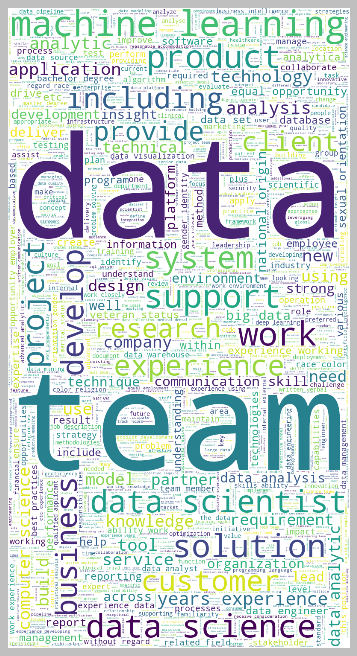

In [108]:
words = " ".join(df2["job_description"])

def punctuation_stop(text):
    "remove punctuation and stop words"
    filtered=[]
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w not in stop_words and w.isalpha():
            filtered.append(w.lower())
    return filtered

words_filtered = punctuation_stop(words)

text= " ".join([ele for ele in words_filtered])

wc = WordCloud(background_color="white", random_state=1, stopwords=STOPWORDS, max_words=2000, width=800, height=1500)
wc.generate(text)

plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


# 4. Model Building

In [109]:
df2.columns

Index(['job_title', 'salary_estimate', 'job_description', 'rating',
       'company_name', 'headquarters', 'size', 'founded', 'type_of_ownership',
       'industry', 'sector', 'revenue', 'competitors', 'hourly',
       'salary_average', 'salary_min', 'salary_max', 'city', 'state',
       'parsed_num', 'years_old', 'company_txt', 'python', 'R_studio', 'spark',
       'aws', 'excell', 'SQL', 'title_category', 'experience_level',
       'description_len', 'compet_nums'],
      dtype='object')

In [110]:
numeric_df.columns

Index(['rating', 'founded', 'salary_average', 'salary_min', 'salary_max',
       'years_old', 'description_len', 'compet_nums'],
      dtype='object')

In [111]:
categorical_df.columns

Index(['job_title', 'salary_estimate', 'job_description', 'company_name',
       'headquarters', 'size', 'type_of_ownership', 'industry', 'sector',
       'revenue', 'competitors', 'city', 'state', 'parsed_num', 'company_txt',
       'title_category', 'experience_level'],
      dtype='object')

In [112]:
boolean_df.columns

Index(['hourly', 'python', 'R_studio', 'spark', 'aws', 'excell', 'SQL'], dtype='object')

In [113]:
model_df = df2[["salary_average", "rating","size", "type_of_ownership", "industry", 
             "sector", "title_category","revenue","hourly","compet_nums","state", "python",
             "SQL","spark","aws","excell", "experience_level","description_len"]]

In [114]:
dummy_df = pd.get_dummies(model_df)

In [115]:
from sklearn.model_selection import train_test_split
x = dummy_df.drop("salary_average", axis=1)
y = dummy_df["salary_average"].fillna(dummy_df["salary_average"].mean()).values # This returns an array which is the data structure advised to be used in model building
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # 0.2 means 80 % is in our train set and 20% in the test set

In [116]:

from sklearn import linear_model # we can import linear model, and from there use both: linearregression and lasso

lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x)
score = lm.score(x,y)
coef = lm.coef_
intercept = lm.intercept_

In [117]:
score

0.6293825454599832

In [118]:
# but to get a summary of the stats using import statsmodels.api as sm is more convinient
import statsmodels.api as sm

x = sm.add_constant(x)
model = sm.OLS(y, x.astype(float)).fit()  # i had to convert x to float to avoid error. This is why using o and 1 may ve preffered over bool
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     7.681
Date:                Sun, 31 May 2020   Prob (F-statistic):           1.57e-73
Time:                        09:29:13   Log-Likelihood:                -3329.5
No. Observations:                 751   AIC:                             6953.
Df Residuals:                     604   BIC:                             7632.
Df Model:                         146                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                56.0468      9.725      5.763      0.000      36.948      75.146
rating                                               -1.5189      1.432     -1.061      0.289      -4.330       1.293
hourly                                              -44.6093      9.766     -4.568      0.000     -63.789     -25.430
compet_nums                                           3.1594      0.870      3.630      0.000       1.450       4.868
python                                                5.6518      2.431      2.325      0.020       0.878      10.426
SQL                                                  -3.8979      2.374     -1.642      0.101      -8.561       0.765
spark                                                 1.4474      2.698      0.537      0.592      -3.851       6.746
aws                                                   1.8971      2.462      0.771      0.441      -2.937       6.732
excell                                                1.0870      2.027      0.536      0.592      -2.893       5.067
description_len                                      -0.0004      0.001     -0.561      0.575      -0.002       0.001
size_-1                                               6.4756      4.032      1.606      0.109      -1.443      14.394
size_1 to 50 employees                                8.2536      4.887      1.689      0.092      -1.343      17.851
size_10000+ employees                                -1.4567      5.168     -0.282      0.778     -11.607       8.694
size_1001 to 5000 employees                           3.7802      3.218      1.175      0.241      -2.539      10.100
size_201 to 500 employees                             8.2013      3.398      2.413      0.016       1.527      14.875
size_5001 to 10000 employees                         -2.9232      4.983     -0.587      0.558     -12.710       6.863
size_501 to 1000 employees                            5.0801      3.796      1.338      0.181      -2.374      12.535
size_51 to 200 employees                              6.3386      3.640      1.741      0.082      -0.810      13.487
size_Unknown                                         22.2973      9.280      2.403      0.017       4.072      40.522
type_of_ownership_-1                                  6.4756      4.032      1.606      0.109      -1.443      14.394
type_of_ownership_College / University               22.4938     20.592      1.092      0.275     -17.946      62.934
type_of_ownership_Company - Private                   9.8523      4.923      2.001      0.046       0.184      19.520
type_of_ownership_Company - Public                   13.1213      5.365      2.446      0.015       2.584      23.659
type_of_ownersh

In [119]:
from sklearn.model_selection import cross_val_score

cv_lm = (cross_val_score(lm, x_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean()


In [120]:
lm_l = linear_model.Lasso(alpha=0.17)
lm_l.fit(x_train, y_train)
cv_Lasso = (cross_val_score(lm_l, x_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean()

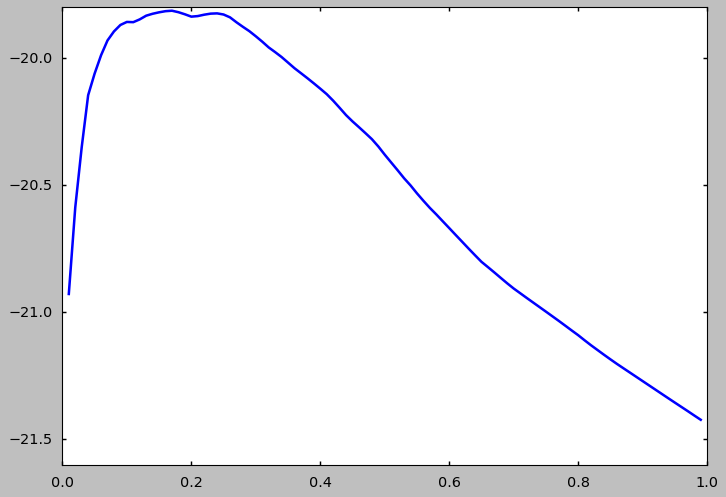

In [121]:
alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lml=linear_model.Lasso(alpha=(i/100)) # from 0.01 to 1
    error.append((cross_val_score(lml, x_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean())
plt.plot(alpha,error)



In [122]:
err_df = pd.DataFrame(tuple(zip(alpha,error)), columns=["alpha", "error"]) 
# we can make a list of tuples to see where our optimal alpha value is

In [123]:
err_df[err_df["error"]==max(err_df["error"])] 
# we can now see what is our optimal alpha value. The lowest error we can get with the lasso model is -19.91

,alpha,error
16,0.17,-19.813505


In [124]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
cv_rf = (cross_val_score(rf, x_train, y_train, scoring = "neg_mean_absolute_error", cv=3)).mean()


In [125]:
cv_rf # we can see a quite lower value which means this is a better model for our prediction 

-15.69498104906937

In [126]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': range(10,300,10), "criterion": ("mse","mae"), "max_features":("auto","sqrt","log2")} 
gs=GridSearchCV(rf,parameters, scoring="neg_mean_absolute_error", cv=3)
gs.fit(x_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [127]:
gs.best_score_ # a bit better than our cv_rf

-15.460775803722498

In [128]:
gs.best_estimator_ # this gives us the best parameters for our rf model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=140, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [129]:
tpred_lm = lm.predict(x_test)
tpred_lml = lm_l.predict(x_test)
tpred_rf = gs.best_estimator_.predict(x_test)

In [130]:
from sklearn.metrics import mean_absolute_error

In [131]:
mean_absolute_error(y_test,tpred_lm)

17.827496390104162

In [132]:
mean_absolute_error(y_test,tpred_lml) # surprinsingly we did worse with lasso

18.69574153537068

In [133]:
mean_absolute_error(y_test,tpred_rf)

12.497661108683227

In [134]:
mean_absolute_error(y_test, (tpred_lm+tpred_rf)/2)

14.401102011401512

# 5. Productionazing the model

In [138]:
import pickle
pickl = {'model': gs.best_estimator_}
pickle.dump( pickl, open( 'model_file' + ".p", "wb" ) )

file_name = "model_file.p"
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']
model.predict(x_test.iloc[1,:].values.reshape(1,-1))
x_test.iloc[1,:].values

array([4.6, False, 0, False, True, True, False, False, 2068, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=object)

In [140]:
list(x_test.iloc[1,:])

[4.6,
 False,
 0,
 False,
 True,
 True,
 False,
 False,
 2068,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0]